In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

import skimage
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft

import scipy.ndimage as spimg 
from scipy.ndimage import fourier_shift
from scipy.ndimage import shift as sp_shift
from scipy.ndimage import rotate
from scipy import stats
from scipy import misc as spmisc
import imageio

import imreg_dft as ird

from PIL import Image

from tqdm import tqdm_notebook as tqdm
import itertools as it
from copy import copy
import pickle as pkl
import pandas as pd
import seaborn as sns

In [2]:
%config Completer.use_jedi = False

In [3]:
with open('/myvol/data2/deep2/images.pkl', 'rb') as file:
    images = pkl.load(file)

In [4]:
batches = ['L10C', 'L20C1', 'L20T', 'L30C', 'L30C8']

## Gene Sets

##### Using the first gene sets:

In [8]:
with open('/myvol/data2/deep2/reg_genes_dict.pkl','rb') as file:
    genes_dict = pkl.load(file)

Make a flat list from the dictionary:

In [9]:
genes = [i for j in list(genes_dict.values()) for i in j]

## Plotting

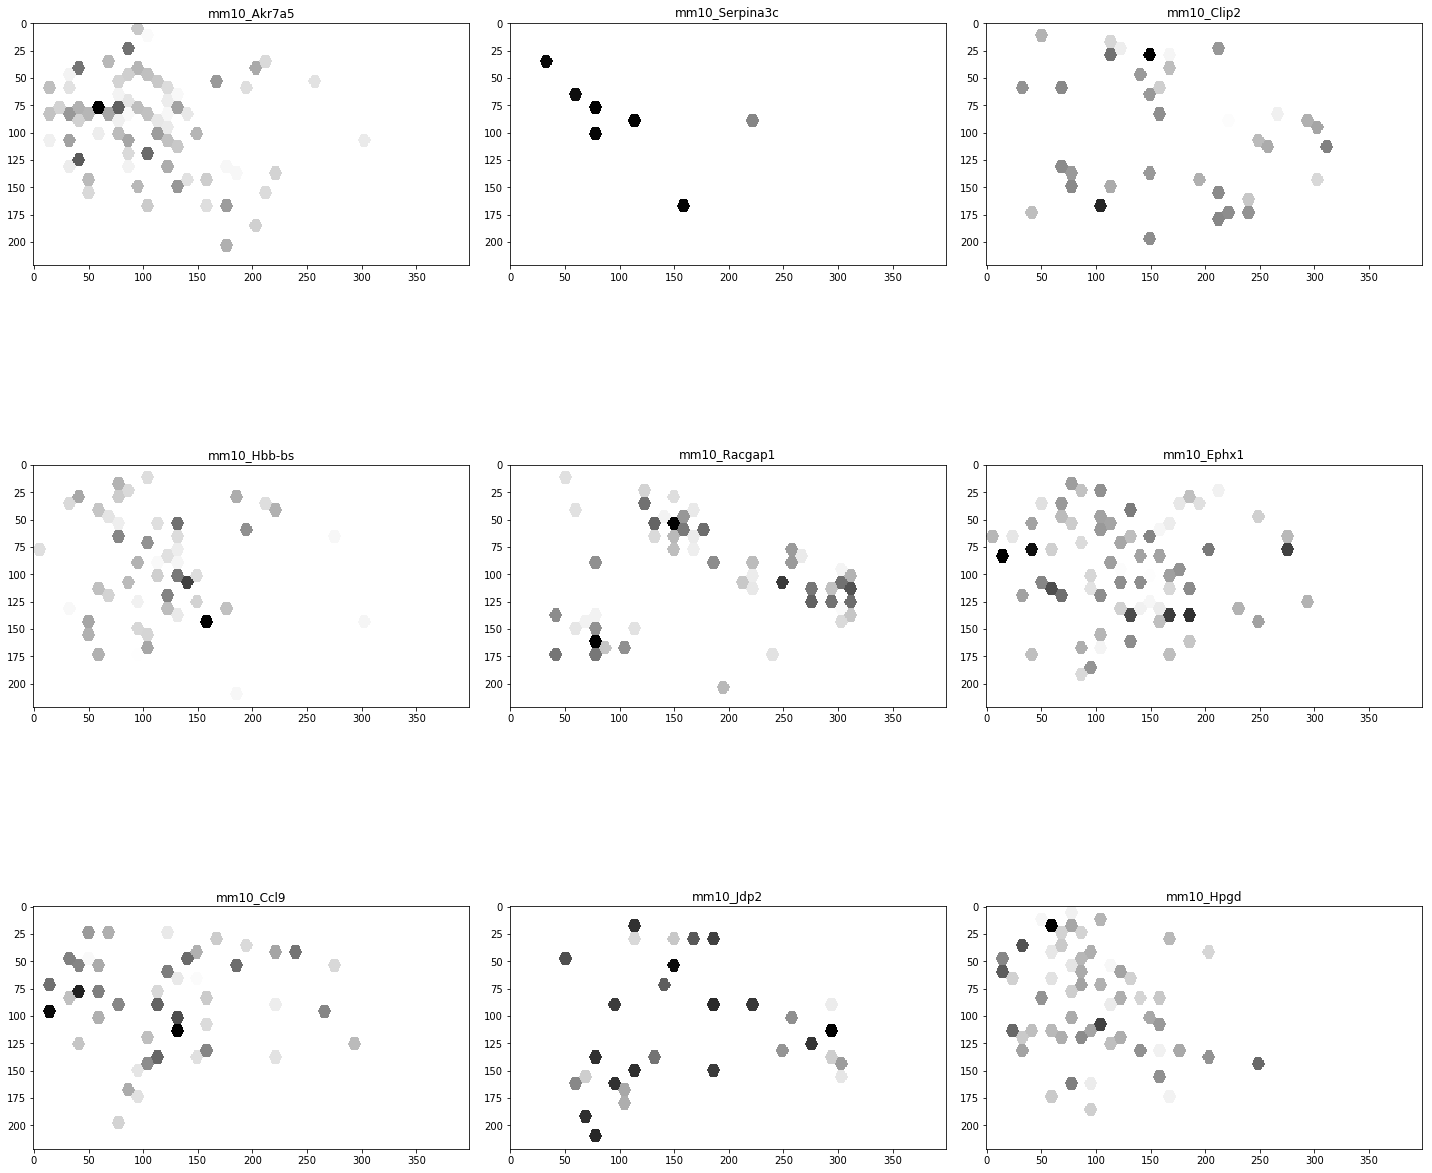

In [10]:
fig, axes = plt.subplots(3,3,figsize=(20,20))
for i, ax in zip(np.random.choice(range(len(genes)), size=9),np.ravel(axes)):
    ax.imshow(images[0][i].todense(), cmap='binary');
    ax.set_title(genes[i])
plt.tight_layout()

In [19]:
[i for i in genes if 'Trf' in i]

[]

In [ ]:
fig, axes = plt.subplots(1,5,figsize=(20,20))
for i, j, ax in zip(list(np.where(genes == 'mm10_4930563H07Rik')[0])*5,range(len(batches)), np.ravel(axes)):
    ax.imshow(images[j][i].todense(), cmap='binary');
plt.tight_layout()

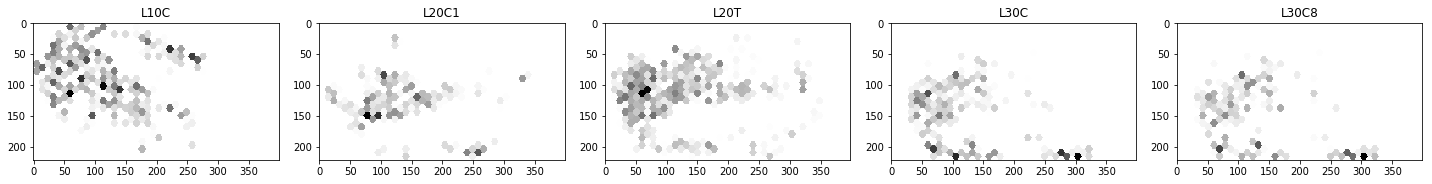

In [14]:
fig, axes = plt.subplots(1,5,figsize=(20,20))
for i, j, ax in zip(list(np.where(genes == 'Alb')[0])*5,range(len(batches)), np.ravel(axes)):
    ax.imshow(images[j][i].todense(), cmap='binary');
    ax.set_title(batches[j])
plt.tight_layout()

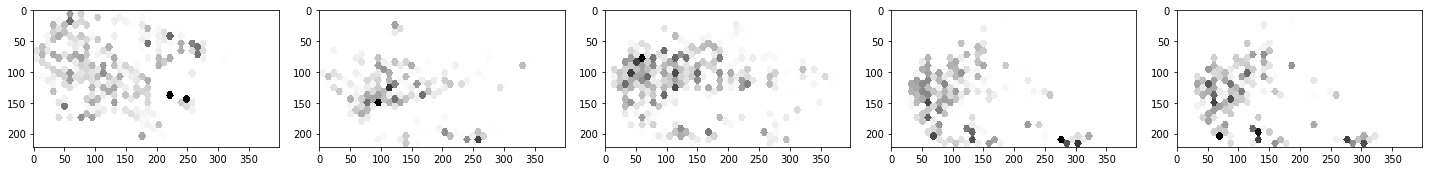

In [15]:
fig, axes = plt.subplots(1,5,figsize=(20,20))
for i, j, ax in zip(list(np.where(genes == 'Trf')[0])*5,range(len(batches)), np.ravel(axes)):
    ax.imshow(images[j][i].todense(), cmap='binary');
plt.tight_layout()

Okay, the first batch I can kinda tell is just flipped and rotated, but the registration algorithm here I don't think accounts for flips, so I think I'll try to just flip it here. I'm going to use the `reshape` parameter of `rotate()` here set to `True` so that I can preserve all the data, but then will crop out the tissue section to keep the same size arrays as the others (222 x 399).

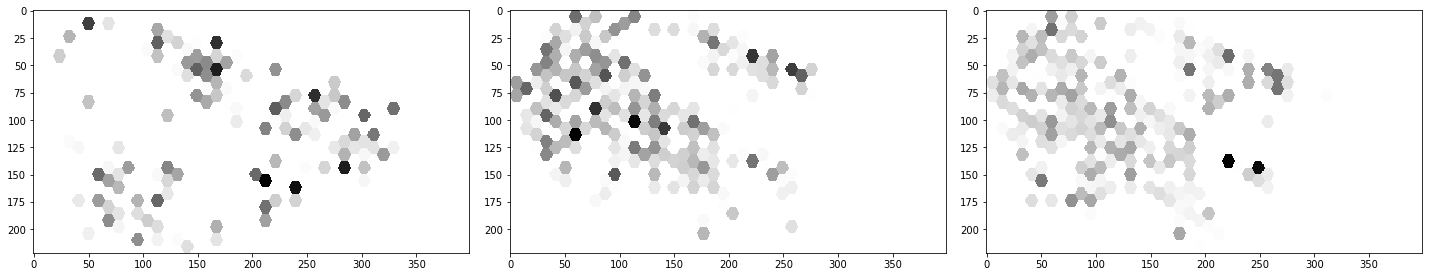

In [18]:
fig, axes = plt.subplots(1,3,figsize=(20,20))
for i, ax in zip(list(map(lambda x: np.where(genes == x)[0][0],['Zfpm2','Alb','Trf'])), np.ravel(axes)):
    ax.imshow(images[0][i].todense(), cmap='binary');
plt.tight_layout()

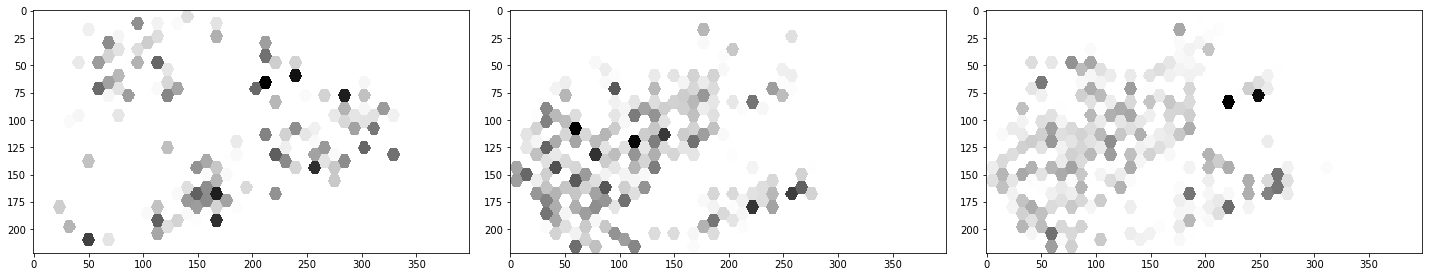

In [19]:
fig, axes = plt.subplots(1,3,figsize=(20,20))
for i, ax in zip(list(map(lambda x: np.where(genes == x)[0][0],['Zfpm2','Alb','Trf'])), np.ravel(axes)):
    ax.imshow(np.round(np.flipud(images[0][i].todense())), cmap='binary');
plt.tight_layout()

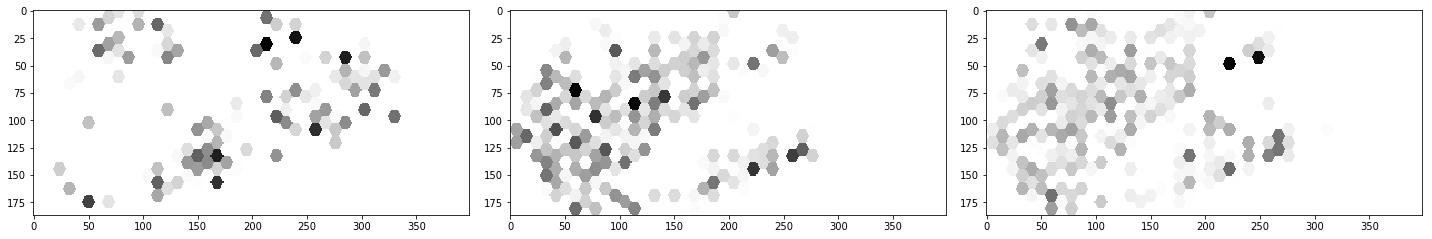

In [20]:
fig, axes = plt.subplots(1,3,figsize=(20,20))
for i, ax in zip(list(map(lambda x: np.where(genes == x)[0][0],['Zfpm2','Alb','Trf'])), np.ravel(axes)):
    ax.imshow(np.round(np.flipud(images[0][i].todense()))[35:257,:399], cmap='binary');
plt.tight_layout()

I don't think the gray background is anything to worry about; I've confirmed its still zero-inflated. Gray background should be all zeros, but not sure why it's not showing up that way.

In [28]:
for gene_img in tqdm(range(len(images[0]))):
    images[0][gene_img] = csr_matrix(np.round(np.flipud(images[0][gene_img].todense())))

The second batch, youjin said, was actually cut a little bit short (which is why it looks so weird compared to the rest). I'm going to drop that one.

In [20]:
batches.pop(1)

'L20C1'

In [29]:
batches

['L10C', 'L20C1', 'L20T', 'L30C', 'L30C8']

Let's do those three major markers one last time...

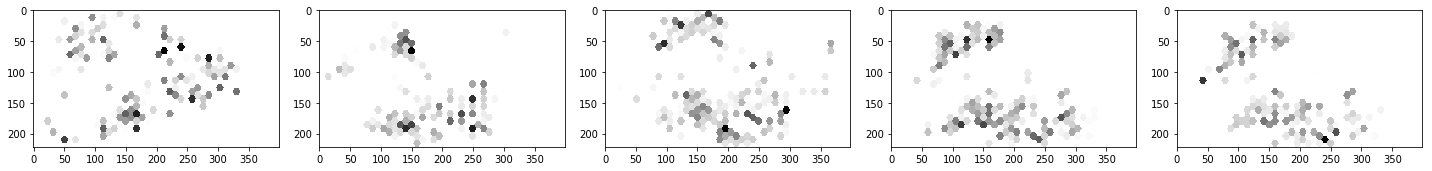

In [30]:
fig, axes = plt.subplots(1,len(batches),figsize=(20,20))
for i, j, ax in zip(list(np.where(genes == 'Zfpm2')[0])*5,range(len(batches)), np.ravel(axes)):
    ax.imshow(images[j][i].todense(), cmap='binary');
plt.tight_layout()

0
0
0
0
0


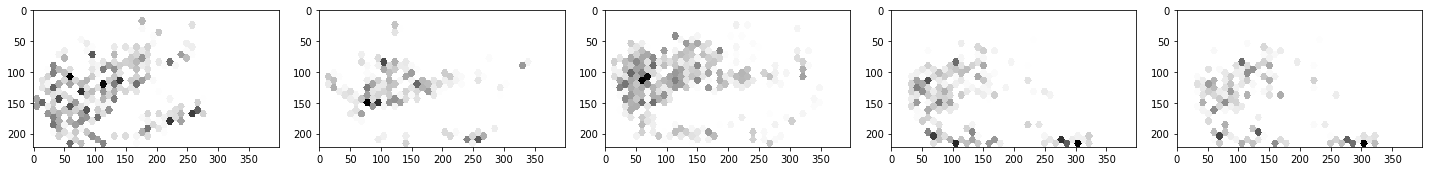

In [35]:
fig, axes = plt.subplots(1,len(batches),figsize=(20,20))
for i, j, ax in zip(list(np.where(genes == 'Alb')[0])*5,range(len(batches)), np.ravel(axes)):
    print(i)
    ax.imshow(images[j][i].todense(), cmap='binary');
plt.tight_layout()

1
1
1
1
1


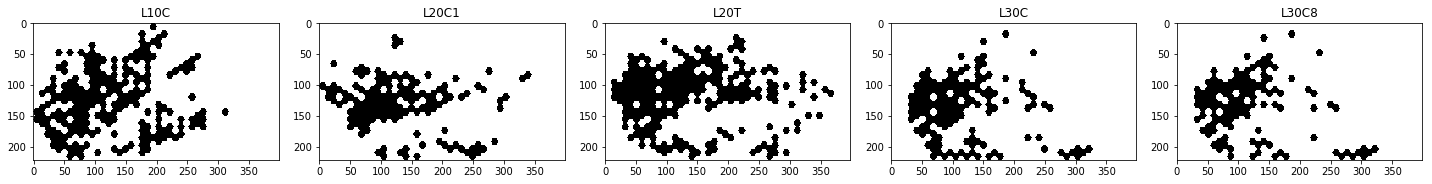

In [96]:
fig, axes = plt.subplots(1,len(batches),figsize=(20,20))
for i, j, ax in zip(list(np.where(genes == 'Trf')[0])*5,range(len(batches)), np.ravel(axes)):
    print(i)
    ax.imshow(images[j][i].todense() > 0, cmap='binary');
    ax.set_title(batches[j])
plt.tight_layout()

So this was the issue the first time: we _don't_ want to increase resolution here, since registering to pixel resolution with hexagons of pixel length 12 are already registering at 12x resolution as compared to the hexagons. This should get us to ~40 um resolution.

In [52]:
images[3][0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [101]:
# the TEMPLATE

result = ird.similarity(spimg.binary_fill_holes(images[3][0].toarray()), spimg.binary_fill_holes(images[2][0].toarray()), numiter=3, constraints={'scale':(1,0)})

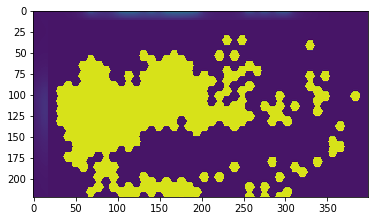

In [102]:
plt.imshow(result['timg'])

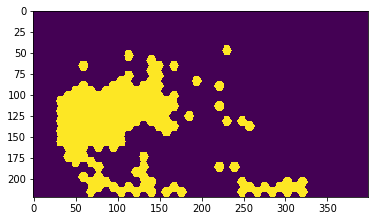

In [103]:
plt.imshow(spimg.binary_fill_holes(images[3][0].toarray()))

### Okay, new plan: use only last three slices, use the binary, hole filled output to register using the new package, and then apply those transformations to the non-binary, non-hole-filled image, and then continue with the algorithm.

In [25]:
scale = 1

In [26]:
est_shifts = pd.DataFrame(0,index=pd.MultiIndex.from_product([batches[1:],['X','Y']]), columns=genes)

In [27]:
for i in tqdm(range(len(genes))):
    gene = genes[i]
    image_1 = images[0][i].todense()
    for j, k in it.product(range(len(batches))[1:],['X','Y']):
        batch = batches[j]
        est_shift, error, diffphase = register_translation(image_1, images[j][i].todense(), scale)
        if k == 'Y':
            est_shifts.loc[(batch,k),gene] = est_shift[0] # Axis ordering is consistent with numpy (e.g. Z, Y, X)
        elif k == 'X':
            est_shifts.loc[(batch,k),gene] = est_shift[1] # Axis ordering is consistent with numpy (e.g. Z, Y, X)


In [28]:
est_shifts

Alb   Trf  Cmss1  Apoe  Pigr  Apoc1  Apoa1  Ahsg    C3  Apob  ...  \
L20T  X -19.0   5.0  -23.0 -33.0  18.0  -11.0    4.0 -25.0  43.0  -5.0  ...   
      Y  -5.0  -4.0  -28.0  27.0  -8.0  -11.0   -6.0  -1.0 -10.0  -5.0  ...   
L30C  X  21.0  17.0   22.0  21.0  16.0   16.0  -12.0  11.0  21.0   1.0  ...   
      Y  18.0  -2.0   -4.0  28.0  10.0   17.0    2.0  10.0   8.0  17.0  ...   
L30C8 X -11.0  -5.0  -15.0  -6.0 -13.0    2.0  -27.0   2.0  -7.0   0.0  ...   
      Y -11.0 -20.0  -23.0 -26.0  32.0    4.0  -26.0  18.0 -25.0 -20.0  ...   

         Styk1  Myo5a  Gbp4  Slc7a1   Mkl1  Cep192  Klf6  Lamc1  Cuedc1  Fgfr1  
L20T  X   22.0   95.0  20.0    51.0  -15.0    23.0  25.0   57.0    -9.0   35.0  
      Y    8.0    1.0  61.0     4.0   11.0   110.0 -13.0   -7.0   -30.0  106.0  
L30C  X    6.0   94.0  17.0    15.0    5.0   -12.0 -48.0   16.0    11.0  -37.0  
      Y   19.0  -13.0   9.0     1.0  -83.0     6.0  26.0    6.0   -96.0  -50.0  
L30C8 X   -7.0 -161.0  34.0    25.0    0.0    30.0  29.0   11.0     2.0   25.0  
      Y    1.0  108.0   0.0    -1.0 -101.0   -21.0  -7.0 -107.0   -90.0  -19.0  

[6 rows x 400 columns]

In [54]:
### THIS ONE LABELED SCALE3 IS ACTUALLY SCALE1, I RERAN IT, CHANGE IT ACCORDINGLY WHEN ITS CORRECTED ###
# est_shifts.to_csv('/myvol/data2/est_shifts.scale3.csv')
# est_shifts = pd.read_csv('/myvol/data2/est_shifts.scale3.csv')[genes].set_index(pd.MultiIndex.from_product([batches[1:],['X','Y']]))

In [29]:
est_shifts.to_csv('/myvol/data2/est_shifts.scale1.geneset2.genesetcsv')
# est_shifts = pd.read_csv('/myvol/data2/est_shifts.scale1.geneset2.csv')[genes].set_index(pd.MultiIndex.from_product([batches[1:],['X','Y']]))

So these are the shifts estimted from two pictures. The question is how to use all the information to register. There's only one right registration, but using different genes yields different registrations. I was thinking about taking either the median or the mode. I'll do median here.

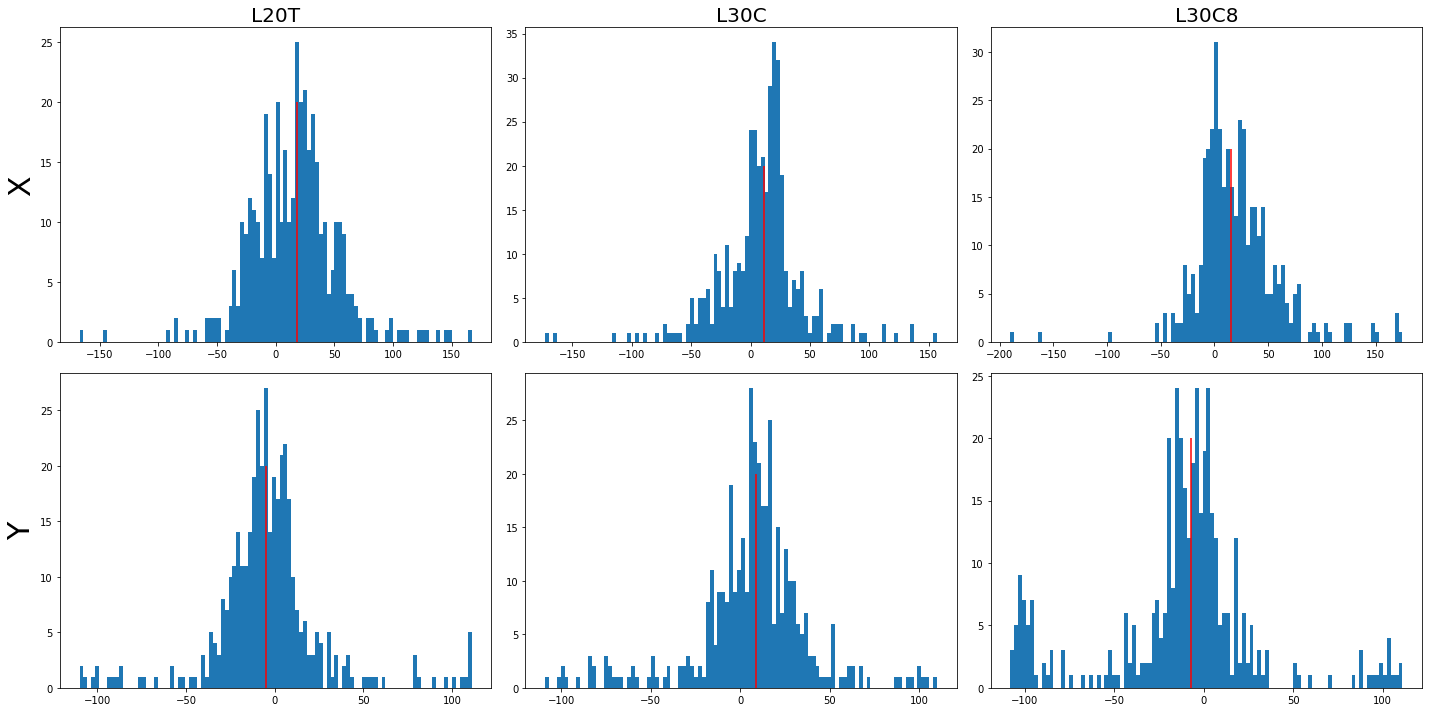

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for i, ax in zip(est_shifts.index, np.ravel(axes.T)):
    a = est_shifts.loc[i].values
    ax.hist(a,bins=100);
    ax.vlines(np.median(a),0,20,color='red')
    
np.ravel(axes.T)[0].set_ylabel('X',size=30)
np.ravel(axes.T)[1].set_ylabel('Y',size=30);

np.ravel(axes.T)[0].set_title(batches[1],size=20)
np.ravel(axes.T)[2].set_title(batches[2],size=20)
np.ravel(axes.T)[4].set_title(batches[3],size=20);
plt.tight_layout();

So there's generally some agreeement among the frames. That's good.

In [37]:
est_shifts = np.round(est_shifts.median(axis=1).values.reshape((3,2))).astype(int) # need to round because median returns float sometimes

In [38]:
est_shifts

array([[18, -5],
       [11,  9],
       [15, -7]])

#### Register frames

In [44]:
def meanmid50(a):
    # need the equals or else percentile might yeild an empty slice
    return np.mean(a[(a >= np.percentile(a,25)) & (a <= np.percentile(a,75))])

In [45]:
stacked_genes = dict()
for gene_ind in tqdm(range(len(genes))):
    gene = genes[gene_ind]

    LRimgs = [images[i][gene_ind].todense() for i in range(5)]
    LRreg = [LRimgs[0]] + [sp_shift(i,j*scale) for i, j in zip(LRimgs[1:],est_shifts)]
    
    LRreg = [np.array(i) for i in LRreg]
    stacked = np.stack(LRreg,axis=2) # stack all registered images

    # PKS use the average of the middle 50% of pixel values to collapse for the initial HRguess because they showed it works well. 
    # I ran both that method and just the regular mean of all values (not shown), and they looked very similar. 
    # The mean takes a fraction of the time to calculate, so I'm just going to use that.
#     print("Making high resolution guess...")


    HRguess = np.median(stacked,axis=2) # take the mean, then round
    
#     HRguess = np.apply_along_axis(meanmid50, 2, stacked) # painfully slow

    stacked_genes[gene] = dict()
    stacked_genes[gene]['gene_ind'] = gene_ind
    stacked_genes[gene]['csr'] = csr_matrix(HRguess)

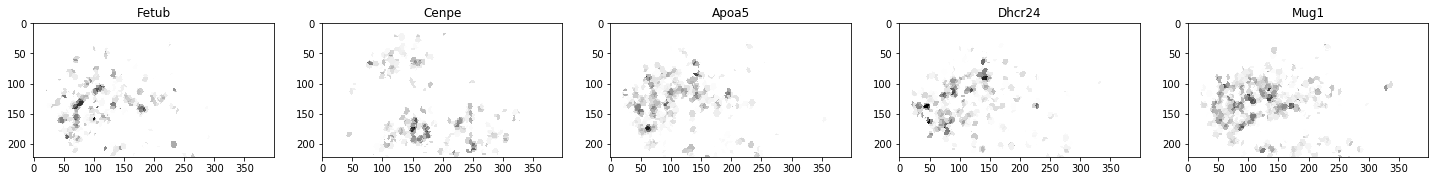

In [48]:
fig, axes = plt.subplots(1,5,figsize=(25,6))
for gene, ax in zip(np.random.choice(list(stacked_genes.keys()),size=5),axes):
    HRguess = stacked_genes[gene]['csr'].todense()
    ax.imshow(HRguess,cmap='binary')
    ax.set_title(gene)

Cool, registration seems to have worked pretty well! Let's try to see some genes from the same cell type.

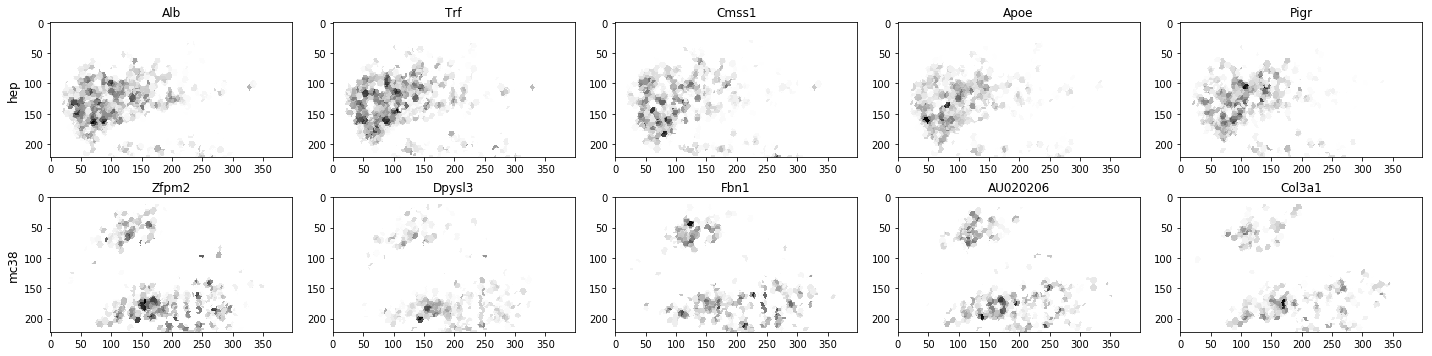

In [49]:
fig, axes = plt.subplots(2,5,figsize=(20,5))
cts = list(genes_dict2.keys())

for ct, row in zip(cts, axes):
    for gene, ax in zip(genes_dict2[ct][:5], row):
        HRguess = stacked_genes[gene]['csr'].todense()
        ax.imshow(HRguess,cmap='binary')
        ax.set_title(gene)
for ax, ct in zip(axes[:,0], cts):
    ax.set_ylabel(ct, rotation=90, size='large')
plt.tight_layout()

When using gene set 1, it didn't seem like the specific hepatocyte clusters were in certain parts of the tissue. The most spatial differentiation is between hepatocyte and mc38. This is when I went back to create gene set 2 and used many more genes.

Now, to stack across all genes...

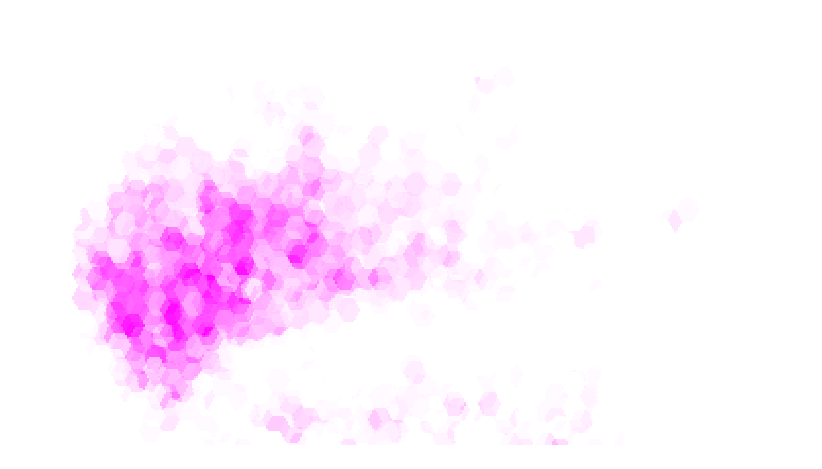

In [51]:
plt.figure(figsize=(15,8))
stacked_hep = np.stack(map(lambda x: stacked_genes[x]['csr'].toarray(), genes_dict2['hep']),axis=2) # stack all registered images
HRguess_hep = np.abs(np.round(stacked_hep.mean(axis=2))) # take the mean, then round
plt.imshow(HRguess_hep,cmap=mpl.colors.LinearSegmentedColormap.from_list('pink',['white','magenta']))
plt.axis('off');

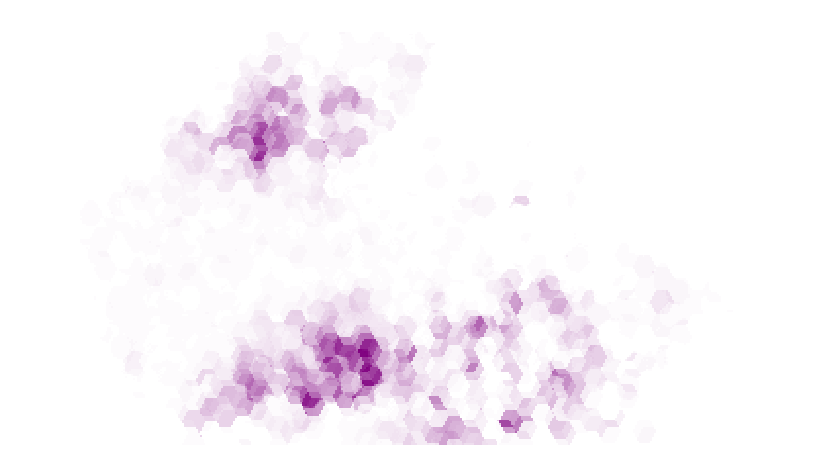

In [52]:
plt.figure(figsize=(15,8))
stacked_mc38 = np.stack(map(lambda x: stacked_genes[x]['csr'].toarray(), genes_dict2['mc38']),axis=2) # stack all registered images
HRguess_mc38 = np.abs(np.round(stacked_mc38.mean(axis=2))) # take the mean, then round
plt.imshow(HRguess_mc38,cmap=mpl.colors.LinearSegmentedColormap.from_list('purple',['white','purple']))
plt.axis('off');

In [54]:
dims = HRguess_hep.shape

In [140]:
hepcolor = (255., 0., 0.)
mc38color = (0., 0., 255.)

In [198]:
hepthresh = 1
mc38thresh = 1

In [199]:
hep_mask = HRguess_hep > hepthresh
mc38_mask = HRguess_mc38 > mc38thresh

hep_RGBA = np.stack([hep_mask*hepcolor[0]/255,
                     hep_mask*hepcolor[1]/255,
                     hep_mask*hepcolor[2]/255, 
                     np.where(hep_mask, HRguess_hep/HRguess_hep.max(),0)],
                    axis=2)
mc38_RGBA = np.stack([mc38_mask*mc38color[0]/255,
                      mc38_mask*mc38color[1]/255,
                      mc38_mask*mc38color[2]/255, 
                      np.where(mc38_mask, HRguess_mc38/HRguess_mc38.max(),0)],
                     axis=2)

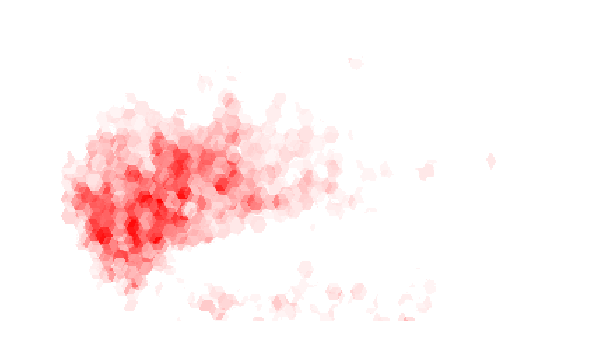

In [200]:
plt.figure(figsize=(10,10))
plt.imshow(hep_RGBA)
plt.axis('off');

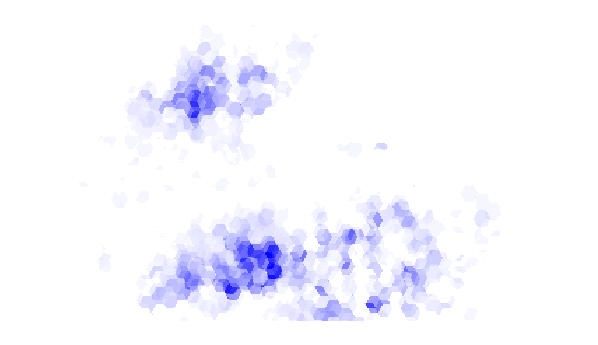

In [201]:
plt.figure(figsize=(10,10))
plt.imshow(mc38_RGBA)
plt.axis('off');

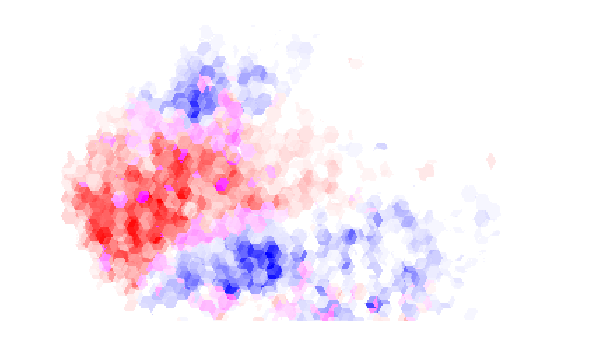

In [202]:
plt.figure(figsize=(10,10))
plt.imshow(hep_RGBA + mc38_RGBA)
plt.axis('off');

In [203]:
hep_RGBA[:,:,0].max()

1.0

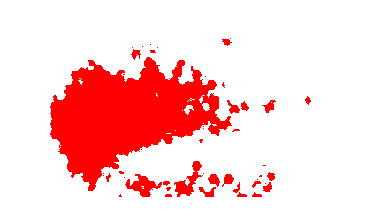

In [204]:
hep_bin = spimg.binary_fill_holes(hep_RGBA)
plt.imshow(hep_bin.astype(float))
plt.axis('off');

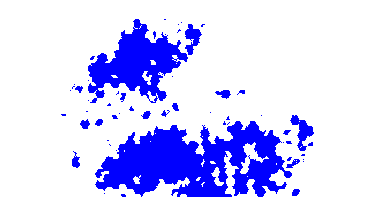

In [205]:
mc38_bin = spimg.binary_fill_holes(mc38_RGBA)
plt.imshow(mc38_bin.astype(float))
plt.axis('off');

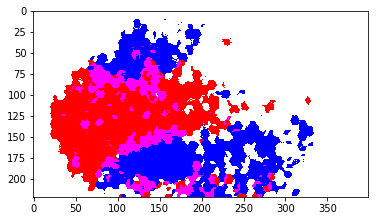

In [206]:
plt.imshow((mc38_bin + hep_bin).astype(float));

Very cool, looks like resolution is increasing a bit.

Going to binarize the data.

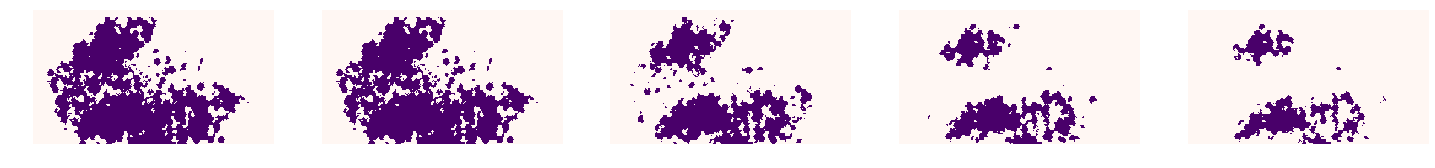

In [44]:
fig, axes = plt.subplots(1,5,figsize=(25,7))
for i, ax in zip([0, 0.5, 1, 3, 5],axes):
    ax.imshow(HRguess_mc38 > i,cmap='RdPu')
    ax.axis('off');

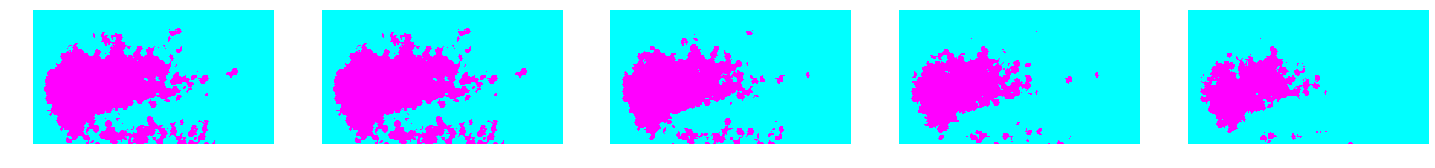

In [45]:
fig, axes = plt.subplots(1,5,figsize=(25,7))
for i, ax in zip([0, 0.5, 1, 3, 5],axes):
    ax.imshow(HRguess_hep > i,cmap='cool')
    ax.axis('off');

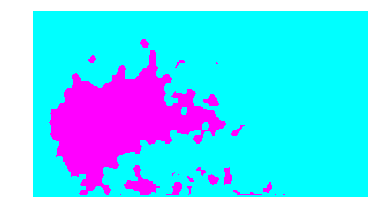

In [247]:
plt.imshow(spimg.morphology.binary_closing(HRguess_hep >= 0.5, structure=np.ones((5,5))),cmap='cool');
plt.axis('off');

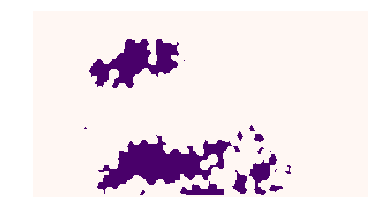

In [248]:
plt.imshow(spimg.morphology.binary_closing(HRguess_mc38 > 3, structure=np.ones((5,5))),cmap='RdPu');
plt.axis('off');

## Extra Code

In [ ]:
stacked_hep = np.stack(map(lambda x: stacked_genes[x]['csr'].toarray(), genes_dict2['hep']),axis=2) # stack all registered images
dims = stacked_hep.shape[:2]
HRguess_hep = np.zeros(dims)
for i, j in tqdm(it.product(range(dims[0]),range(dims[1])),total=dims[0]*dims[1]):
    HRguess_hep[i, j] = meanmid50(stacked_hep[i,j,:])
plt.imshow(HRguess_hep,cmap='binary')
plt.axis('off');

In [ ]:
stacked_mc38 = np.stack(map(lambda x: stacked_genes[x]['csr'].toarray(), genes_dict2['mc38']),axis=2) # stack all registered images
dims = stacked_mc38.shape[:2]
HRguess_mc38 = np.zeros(dims)
for i, j in tqdm(it.product(range(dims[0]),range(dims[1])),total=dims[0]*dims[1]):
    HRguess_mc38[i, j] = meanmid50(stacked_mc38[i,j,:])
plt.imshow(HRguess_mc38,cmap='binary')
plt.axis('off');

In [ ]:
stacked_hep = np.stack(map(lambda x: stacked_genes[x]['csr'].toarray(), genes_dict2['hep']),axis=2) # stack all registered images
dims = stacked_hep.shape[:2]
HRguess_hep = np.zeros(dims)
for i, j in tqdm(it.product(range(dims[0]),range(dims[1])),total=dims[0]*dims[1]):
    HRguess_hep[i, j] = np.median(stacked_hep[i,j,:])
plt.imshow(HRguess_hep,cmap='binary')
plt.axis('off');

In [ ]:
stacked_mc38 = np.stack(map(lambda x: stacked_genes[x]['csr'].toarray(), genes_dict2['mc38']),axis=2) # stack all registered images
dims = stacked_mc38.shape[:2]
HRguess_mc38 = np.zeros(dims)
for i, j in tqdm(it.product(range(dims[0]),range(dims[1])),total=dims[0]*dims[1]):
    HRguess_mc38[i, j] = np.median(stacked_mc38[i,j,:])
plt.imshow(HRguess_mc38,cmap='binary')
plt.axis('off');

In [ ]:
plt.hist(np.ravel(HRguess_hep),bins=200);
plt.yscale('log');

In [ ]:
np.unique(np.ravel(HRguess_hep),return_counts=True)

In [ ]:
plt.hist(np.ravel(HRguess_mc38),bins=200);
plt.yscale('log');

In [ ]:
np.unique(np.ravel(HRguess_mc38),return_counts=True)

In [184]:
HRguess_hep = HRguess_hep > 5

In [185]:
HRguess_mc38 = HRguess_mc38 > 5